In [ ]:
# Run this cell first!
from client.api.notebook import Notebook
ok = Notebook('lab02.ok')

# Lab 2: Derivative-free methods

This ungraded assignment is composed of **15 exercises** on black-box optimization, divided in three parts. The first part will focus on the implementation of grid search, the second part on the implementation of random search, and the third part on the implementation of cross-entropy method. In order to understand and solve the exercises, and more generally to gain the maximum benefit from this assignment, it is highly recommended that you read **Chapter 2** in the course notes available on [Blackboard](https://esiee.blackboard.com/).

<span style="color:#a50e3e;">**IMPORTANT: Please refer to Chapter 2 as you work through this assignment.**</span>

## Instructions

 - Download a copy of this notebook from [Blackboard](https://esiee.blackboard.com/).
 
 
 - Run `jupyter notebook` and open the `.ipynb` file.
   - *Keep the notebook inside the folder it was downloaded with. This folder contains all the dependencies needed for the notebook to work properly.*


 - **Work alone or with a partner** to solve the quizzes. 
   - *You are supposed to fill in or modify the code marked with the comment `# YOUR CODE HERE`*
   - *You can check your answers by running the tests provided at the end of each quiz*

## Contents

- **Part 1.** Grid search

| Exercise | Topic |
|----------|------|
| [Quiz 1](#Quiz-1) | Random sampling |
| [Quiz 2](#Quiz-2) | Step 1 |
| [Quiz 3](#Quiz-3) | Step 2 |
| [Quiz 4](#Quiz-4) | Step 3 |
| [Quiz 5](#Quiz-5) | Grid search |
| [Quiz 6](#Quiz-6) | Cost function |
| [Quiz 7](#Quiz-7) | Optimization |


- **Part 2.** Random search

| Exercise | Topic |
|----------|------|
| [Quiz 8](#Quiz-8) | Step 1 |
| [Quiz 9](#Quiz-9) | Step 2 |
| [Quiz 10](#Quiz-10) | Random search |
| [Quiz 11](#Quiz-11) | Optimization |


- **Part 3.** Cross-entropy method

| Exercise | Topic |
|----------|------|
| [Quiz 12](#Quiz-12) | Step 1 |
| [Quiz 13](#Quiz-13) | Step 2 |
| [Quiz 14](#Quiz-14) | Cross-entropy method  |
| [Quiz 15](#Quiz-15) | Optimization |

## Required packages

For this assignment, you need to import the following packages.
- [**Numpy**](www.numpy.org) - The library for scientific computing in Python.
- [**Matplotlib**](http://matplotlib.org) - The library for plotting graphs in Python.

<!--
- [**Autograd**](https://github.com/HIPS/autograd) - The library for automatic differentiation of Numpy code.
-->

In [1]:
import numpy as np
import matplotlib.pyplot as plt

*Make sure to run the next cells. They gather the code for the fancy visualization.*

In [2]:
import ipywidgets as widgets

def generate_points(N=20, seed=42):
    np.random.seed(seed)
    x = np.random.rand(N)
    y = 0.5*x + 2 + 0.05 * np.random.randn(N)
    return x, y

def draw_fitting(x, y, a, b):
    plt.scatter(x, y, s=50, edgecolor='k', zorder=2, alpha=0.7)
    plt.xlabel("$x$", fontsize=14)
    plt.ylabel("$y$", fontsize=14)
    plt.grid()
    plt.xlim([x.min()-0.1, x.max()+0.1])
    plt.ylim([y.min()-0.1, y.max()+0.1])
    plt.plot(np.vstack([x,x]), np.vstack([y,a*x+b]), '--k', alpha=0.5)
    plt.plot(x, a*x+b, 'r', linewidth=3, alpha=0.9)
    plt.title('y = {:.2f}'.format(a) + ' x + {:.2f}'.format(b), fontsize = 18)
    
def draw_contours(x, y):
    from matplotlib.colors import LogNorm
    a_values, b_values = np.meshgrid(np.linspace(-1,2.5,100), np.linspace(1,2.7,100))
    J_values = np.sum((a_values.flatten()[:,None] * x + b_values.flatten()[:,None] - y)**2, axis=1)
    J_values = J_values.reshape(a_values.shape)
    data = a_values, b_values, J_values
    cs = plt.contour(*data, levels=np.logspace(-1.5,2,9), norm=LogNorm(), alpha=.4, colors = 'k')
    plt.clabel(cs, inline=1, fontsize=10)
    plt.contourf(*data, levels=np.logspace(-1.5,2,9), norm=LogNorm(), cmap='jet', alpha=.4)
    plt.xlabel("Slope (a)", fontsize=14)
    plt.ylabel("Intercept (b)", fontsize=14)
    
def draw_optimization(x, y, a, b, lines):
    draw_contours(x, y)
    plt.scatter(history[:,0], history[:,1], color='w', s=80, edgecolor='k', alpha=0.9, zorder=5)
    plt.plot([a], [b], '*', mec='w', mfc='r', mew=2, ms=25, alpha=0.9, zorder=5)
    if lines:
        plt.plot(history[:,0], history[:,1], color='k', alpha=0.7, linewidth=2, zorder=2)
    plt.plot([ a, a], [1,b], '--k', alpha=0.5)
    plt.plot([-1, a], [b,b], '--k', alpha=0.5)
    cost = np.sum((a * x + b - y)**2)
    plt.title("J(a,b) = {:2.4f}".format(cost), fontsize=18, color='k')
    plt.xlim(-1,2.5)
    plt.ylim( 1,2.7)
    
def show_history(w, history, lines=True):
    x, y = generate_points()
    a, b = w[0], w[1]
    fig = plt.figure(figsize=(13,5))
    fig.add_subplot(121)
    draw_fitting(x, y, a, b)
    fig.add_subplot(122)
    draw_optimization(x, y, a, b, lines)
    plt.tight_layout()
    plt.show()

In [3]:
def create_optimization_panel():
    x, y = generate_points()
    draw_contours(x, y)
    point, = plt.plot([], [], '*', mec='w', mfc='r', mew=3, ms=30, alpha=0.9, zorder=5)
    xline, = plt.plot([], [], '--k', alpha=0.5)
    yline, = plt.plot([], [], '--k', alpha=0.5)
    ax = plt.gca()
    return ax, point, xline, yline, x, y

def update_optimization_panel(a, b, state):
    ax, point, xline, yline, x, y = state
    point.set_data([a], [b])
    xline.set_data([ a, a], [1,b])
    yline.set_data([-1, a], [b,b])
    cost = np.sum((a * x + b - y)**2)
    ax.set_title("J(a,b) = {:2.4f}".format(cost), fontsize=18, color='k')

def create_fitting_panel():
    x, y = generate_points()
    plt.scatter(x, y, s=50, ec='k', zorder=2, alpha=0.7)
    plt.xlabel("$x$", fontsize=14)
    plt.ylabel("$y$", fontsize=14)
    plt.grid()
    plt.xlim([x.min()-0.1, x.max()+0.1])
    plt.ylim([y.min()-0.1, y.max()+0.1])
    vdist = [plt.plot([], [], '--k', alpha=0.5)[0] for i in x]
    line, = plt.plot([], [], 'r', linewidth=3, alpha=0.9)
    ax = plt.gca()
    return ax, vdist, line, x, y
    
def update_fitting_panel(a, b, state):
    ax, vdist, line, x, y = state
    for i, v in enumerate(vdist):
        v.set_data([x[i],x[i]], [a*x[i]+b,y[i]])
    line.set_data(x, a*x+b)
    ax.set_title('y = {:.2f}'.format(a) + ' x + {:.2f}'.format(b), fontsize = 18)
    
def create_widget():
    fig = plt.figure(figsize=(13,5))
    fig.add_subplot(121)
    fit_state = create_fitting_panel()
    fig.add_subplot(122)
    optim_state = create_optimization_panel()
    plt.tight_layout()
    plt.close(fig)
    def update_plot(a, b):
        update_fitting_panel(a, b, fit_state)
        update_optimization_panel(a, b, optim_state)
        return fig
    a_slider = widgets.FloatSlider(0, min=-1, max=2, step=0.0001, description='Slope (a):', continuous_update=False)
    b_slider = widgets.FloatSlider(1.9, min=1, max=2.5, step=0.0001, description='Intercept (b):', continuous_update=False)
    widgets.interact(update_plot, a=a_slider, b=b_slider)

## Part 1. Grid search

Grid search is an optimization algorithm that finds the minimum of a function $J({\bf w})$ in three steps.

- **Step 1.** Select some points ${\bf w}_1, \dots, {\bf w}_K$.
- **Step 2.** Compute the function values $J({\bf w}_1), \dots, J({\bf w}_K)$.
- **Step 3.** Find the point ${\bf w}_k$ with the smallest value $J({\bf w}_k)$.

Please refer to Section 2.3 of the [course notes](https://persointra.esiee.fr/~chierchg/optimization/02/grid_search.html) and the [lecture slides](https://esiee.blackboard.com) for more details.

### Quiz 1

Let's start by implementing the first step of grid search, which is to select the points ${\bf w}_1, \dots, {\bf w}_K$. For the time being, you will assume that these points are scalar values. Your first task is to select random values from a given interval, as shown below.

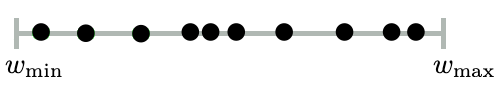

---

> **Create a vector with random values between $w_\min$ and $w_\max$.** 

> *Hints:*
> - Create a vector of length `n_points` with random values between 0 and 1. 
> - Multiply the vector by $(w_\max - w_\min)$, then add $w_\min$.
> - [`np.random.rand()`](https://numpy.org/doc/1.18/reference/random/generated/numpy.random.rand.html)

In [4]:
np.random.seed(21)

# These are the parameters to work with
n_points = 8
wmin = 3
wmax = 5

points = None # YOUR CODE HERE

In [ ]:
ok.grade("sampling_scalars");

### Quiz 2

Let's generalize the implementation of the first step of grid search. Your task is to select points ${\bf w}_1, \dots, {\bf w}_K$ that are random vectors of arbitrary size $N$. The figure below illustrates an example of random points drawn from a 2D space.

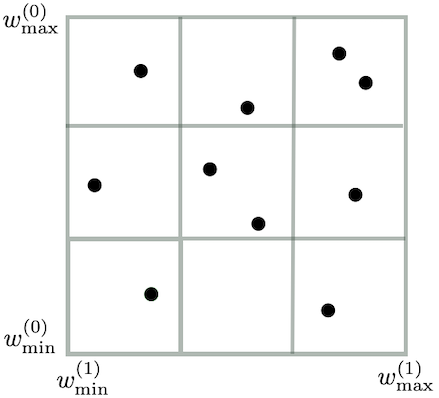

---

> **Create a matrix such that the $n$-th colum has random values between $w_\min^{(n)}$ and $w_\max^{(n)}$.** 

> *Hints:*
> - Create a matrix of shape `(n_points, wmin.size)` with random values between 0 and 1. 
> - Multiply each column `n` by `(wmax[n] - wmin[n])`, then add `wmin[n]`. 
> - Since the matrix has as many columns as the elements of the vectors `wmin` and `wmin`, you can exploit broadcasting to rescale all the columns simultaneously with one line of code. 
> - [`np.random.rand()`](https://numpy.org/doc/1.18/reference/random/generated/numpy.random.rand.html)

In [6]:
np.random.seed(42)

# These are the parameters to work with
n_points = 10
wmin = np.array([3, -1, 7.5])
wmax = np.array([5,  2, 8.5])

points = None # YOUR CODE HERE

In [ ]:
ok.grade("sampling_vectors");

### Quiz 3

Let's focus on the second step of grid search, which is to compute the function values $J({\bf w}_1), \dots, J({\bf w}_K)$. To do this, you are given two things: 
 - a python function that takes a point ${\bf w}$ and returns the scalar $J({\bf w})$, 
 - a list of points stacked in a matrix. 
 
Your task is to loop over the matrix rows, call the function on each single row, and store the returned values in a list.

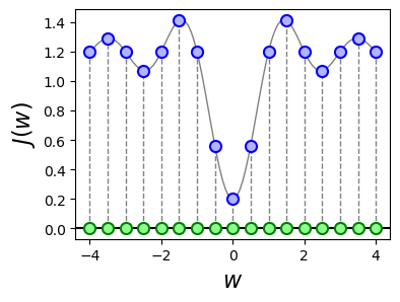

---

> **Apply a function to each row of a matrix, and store the returned values in a list.**

>*Hints:*
>
>- Loop over each row `w` of the matrix, call the function `cost_fun(w)`, and append the returned value to the list `costs`.
>
>- You can loop over the rows of a matrix as follows
>```
my_list = []
for row in matrix:
    c = do_something(row)
    my_list.append(c)
>```
>The above command fills a list with the values returned by the function `do_something()` called on each `row` of `matrix`. 
>- In python, there exists a concise syntax to do exactly the same as above:
>```
my_list = [do_something(row) for row in matrix]
>```
>Note that `my_list` is a python list. Follow up with `np.array(my_list)` if you need to convert the list into a numpy array.


In [8]:
np.random.seed(3)

# These are the items to work with
cost_fun = lambda w: (w[0] - 1)**2 + (w[1] - 2)**2
points = np.random.rand(5, 2)

costs = None # YOUR CODE HERE

In [ ]:
ok.grade("compute_costs");

### Quiz 4


Lastly, let's work on the third step of grid search, which is to find the point ${\bf w}_{k^*}$ with the minimum function value $J({\bf w}_{k^*}) = \min\{J({\bf w}_1), \dots, J({\bf w}_K)\}$. To do this, you are given two things: 
- a list of points ${\bf w}_1, \dots, {\bf w}_K$
- a list of corresponding function values $J({\bf w}_1), \dots, J({\bf w}_K)$. 

Your task is to find the index $k^*$ of the smallest function value $J({\bf w}_{k^*})$, which you can then use to select the minimum point ${\bf w}_{k^*}$.

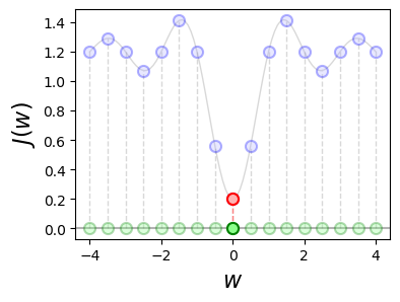

---

> **Find the index $k$ of the minimum element of a vector, then select the $k$-th row of a matrix.**

> *Hints:*
> - Find the index `k` of the smallest value in `costs`, and fetch the `k`-th row of the matrix `points`. 
>
> - `matrix[k]` selects the k-th row of a matrix
>
> - [`np.argmin()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmin.html)

In [10]:
np.random.seed(7)

# These are the items to work with
points = np.random.randint(10, size=(5, 2))
costs = list(np.random.rand(5))

min_index = None # YOUR CODE HERE
min_point = None # YOUR CODE HERE

In [ ]:
ok.grade("find_minimum");

### Quiz 5

You are now ready to implement grid search by putting together the three steps that you implemented previously.

---

> **Implement a function that finds the minimum point of $J({\bf w})$ via grid search.**

> The function takes the following inputs:
>
>- `cost_fun` - Function that can be called with one input array ${\bf w}$, returning a scalar value $J({\bf w})$.
>
>- `wmin` - Vector with the min values of each variable in ${\bf w}=[w_1,\dots,w_N]$.
>
>- `wmax` - Vector with the max values of each variable in ${\bf w}=[w_1,\dots,w_N]$.
>
>- `n_points` - Number of points to be drawn from the search space indicated by `wmin` and `wmax`.
>
> The function returns two outputs:
>
>- `w` - Minimum point found by the algorithm.
>
>- `history` - Lists of points evaluated during the optimization process.

> *Hints:*
>
> - **Step 1.** Create a random matrix `points` of shape `(n_points, wmin.size)`, where the values in the column `i` must be between `wmin[i]` and `wmax[i]`. Note that `wmin` and `wmax` are the same size. 
> - **Step 2.** Loop over each row `w` of `points`, call the function `cost_fun(w)`, and append the returned value to the list `costs`.
> - **Step 3.** Find the index `k` of the smallest value in `costs`, and fetch the `k`-th row of the matrix `points`.

In [12]:
def grid_search(cost_fun, wmin, wmax, n_points = 1000):
    """
    Finds the minimum of a function.
    
    Arguments:
    cost_fun -- cost function    | callable that takes an input 'w' and returns the cost 'J(w)'
    wmin     -- min values       | vector of shape (N,)
    wmax     -- max values       | vector of shape (N,)
    n_points -- number of points | integer
    
    Returns:
    w -- minimum point | vector of shape (N,)
    """
    
    # Convert to numpy vectors
    wmin = np.array(wmin)
    wmax = np.array(wmax)
        
    # Create a matrix of shape (n_points, wmin.size)
    points = None # YOUR CODE HERE
    
    # Apply 'cost_fun' of each row of 'points'
    costs = None # YOUR CODE HERE
    
    # Find the index of the smallest value in 'costs'
    k = None # YOUR CODE HERE
    
    # Select the k-th row of 'points'
    w = None # YOUR CODE HERE
        
    return w, points[np.argsort(costs)[::-1]]

In [ ]:
ok.grade("grid_search");

### Quiz 6


Congratulations! You implemented your first optimization algorithm. The time has come to test it on a concrete optimization problem. You will work on the line fitting problem described in Section 2.1 of the [course notes](https://persointra.esiee.fr/~chierchg/optimization/02/example.html) and the [lecture slides](https://esiee.blackboard.com), which consists of

$$ \operatorname*{minimize}_{a,b}\;\; \underbrace{\sum_{p=1}^P (a x_p + b - y_p)^2}_{J(a,b)}. $$

Grid search requires that you provide the cost function to be minimized. You will now work on this.

---

> **Implement a function that takes the variables $(a, b)$, the points $(x_p,y_p)$, and returns the scalar value $J(a,b)$ defined above.**

> The function takes the following inputs:
>
>- `w` - A vector holding the parameters $a$ and $b$.
>
>- `x` - A vector holding the x-coordinates $x_1,\dots,x_P$.
>
>- `y` - A vector holding the y-coordinates $y_1,\dots,y_P$.
>
>Moreover, the function returns one output:
>
>- `cost` - Scalar value $J(a,b)$ defined above.

In [14]:
def sse_cost(w, x, y):
    """
    Evaluate the sum of squared errors.
        
    Arguments:
    w -- vector of shape (2,) | w[0]: slope - w[1]: intercept 
    x -- vector of shape (n,)
    y -- vector of shape (n,)
    
    Returns:
    cost -- scalar, sum of squared error
    """
    
    # slope and intercept
    a = w[0]
    b = w[1]
            
    # Evaluate the line 'ax + b' for all the x-coordinates
    y_hat = None # YOUR CODE HERE
    
    # Compute the squared difference with the y-coordinates
    sq_err = None # YOUR CODE HERE
    
    # Compute the sum of squared errors
    sse = None # YOUR CODE HERE
    
    return sse

In [ ]:
ok.grade("sse_cost");

The figure below plots the contours of the function $J(a,b)$. Move the slider to manually find the values of $a$ and $b$ that minimize this function.

In [16]:
create_widget()

### Quiz 7

> **Use grid search to find an approximate solution $(a,b)$ to the line fitting problem.**

>*Hints:*
>- Your task is to set the arguments `wmin`, `wmax`, `n_points` of the function `grid_search`.
>- Since the line fitting problem has two variables, set `wmin` to $[a_\min, b_\min]$ and `wmax` to $[a_\max, b_\max]$, both at your choice.
>- Try different values for `wmin`, `wmax`, `n_points` to see how they affect the solution found by grid search.
>- The figure below shows the solution found by grid search, along with all the points generated during the optimization process.

In [17]:
# Data for the line fitting problem (blue points in the figure above)
x, y = generate_points()

# Cost function (with 'x' and 'y' used as data)
cost_fun = lambda w: sse_cost(w, x, y)

# Search space
wmin = None # YOUR CODE HERE
wmax = None # YOUR CODE HERE

# Number of points to search
n_points = None # YOUR CODE HERE

# Optimization
w, history = grid_search(cost_fun, wmin, wmax, n_points)

# Visualization
show_history(w, history, lines=False)

## Part 2. Random search

Random search is an optimization algorithm that finds the minimum of a function $J({\bf w})$ by sequentially refining an initial point.

- Start from an initial point ${\bf w}_0$
- Fix a positive step-size $\alpha_0$
- Repeat for $k=0,1,\dots,K_{\max}$
  - **Step 1.** Select a fixed number $S$ of random directions ${\bf d}_{k}^{(1)},\dots,{\bf d}_{k}^{(S)}$
  
  - **Step 2.** Find the direction ${\bf d}_{k}^{(s^*)}$ leading to the smallest function value, that is $s^* = \arg\min\{J({\bf w}_{k} + \alpha_k \,{\bf d}_k^{(1)} ), \dots, J({\bf w}_{k} + \alpha_k \,{\bf d}_k^{(S)} )\}$.
    
  - **Step 3.**  Make the update ${\bf w}_{k+1} = {\bf w}_{k} + \alpha_k \,{\bf d}_k^{(s^*)}$ when $J({\bf w}_{k} + \alpha_k \,{\bf d}_k^{(s^*)}) < J({\bf w}_k)$, otherwise set ${\bf w}_{k+1} = {\bf w}_k$ and start over. 
  
  - **Step 4.** Increase the step-size $\alpha_{k+1} = \alpha_{k} 1.5$ when $J({\bf w}_{k} + \alpha_k \,{\bf d}_k^{(s^*)}) < J({\bf w}_k)$, otherwise reduce the step-size $\alpha_{k+1} = \alpha_{k} 1.5^{-1/4}$.

Please refer to Section 2.4 of the [course notes](https://persointra.esiee.fr/~chierchg/optimization/02/random_search.html) and the [lecture slides](https://esiee.blackboard.com) for more details.

### Quiz 8

Let's start by implementing the first step of random search, which is to select some directions ${\bf d}_{k}^{(1)},\dots,{\bf d}_{k}^{(S)}$. To do this, you can select random vectors ${\bf w}_1, \dots, {\bf w}_S$ with zero mean and unitary variance, and divide each of them by its norm, obtaining ${\bf d}_{k}^{(s)} = \frac{{\bf w}_s}{\|{\bf w}_s\|}$ for each $s=1,\dots,S$. As illustrated in the figure below, this process generates random points drawn from the unit circle.

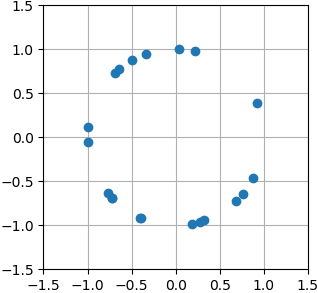

---

> **Create a matrix whose rows are random vectors from the unit circle.**

> *Hints:*
> - Create a matrix of shape `(n_points, n_vars)`, where each element is drawn from a normal distribution $\mathcal{N}(0,1)$.
> - Divide each row by its norm. It should automatically use broadcasting.
> - [`np.random.randn()`](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.randn.html)
> - [`np.linalg.norm()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html)


In [18]:
np.random.seed(8)

# These are the parameters to work with
n_points = 5
n_vars = 3

points = None # YOUR CODE HERE
row_norms = None # YOUR CODE HERE
directions = None # YOUR CODE HERE

In [ ]:
ok.grade("circle_sampling");

### Quiz 9

Now, let's focus on the second step of random search, which is to determine the direction leading to the smallest function value, or said more concretely, find the index $s^* = \arg\min\{ J({\bf w}_{k} + \alpha_k \,{\bf d}_k^{(1)} ), \dots, J({\bf w}_{k} + \alpha_k \,{\bf d}_k^{(S)} )\}$. To do this, you are given three things: the current point ${\bf w}_{k}$, the current step-size $\alpha_k$, and a list of directions ${\bf d}_{k}^{(1)}, \dots, {\bf d}_{k}^{(S)}$. Your task is to 

1. add the current point to each direction scaled by the step-size
  
  $$
  \begin{aligned}
  {\bf \bar{w}}_{k+1}^{(1)} &= {\bf w}_{k} + \alpha_k \,{\bf d}_k^{(1)}\\
  {\bf \bar{w}}_{k+1}^{(2)} &= {\bf w}_{k} + \alpha_k \,{\bf d}_k^{(2)}\\
  &\;\vdots\\
  {\bf \bar{w}}_{k+1}^{(S)} &= {\bf w}_{k} + \alpha_k \,{\bf d}_k^{(S)},\\
  \vphantom{.}
  \end{aligned}
  $$
  
- compute the function values $J({\bf \bar{w}}_{k+1}^{(1)} ), \dots, J({\bf \bar{w}}_{k+1}^{(S)} )$, 

- find the index $s$ of the smallest function value.

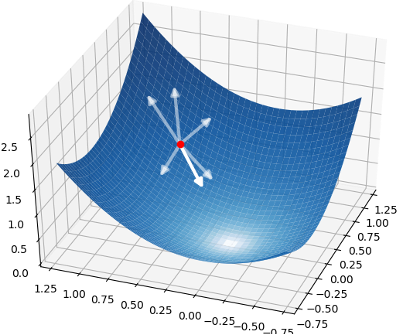

---

> **Find the index $s^*$ of the smallest value in the list $J({\bf w}_{k} + \alpha \,{\bf d}_k^{(1)}), \dots, J({\bf w}_{k} + \alpha \,{\bf d}_k^{(S)})$.**

> *Hints:*
> - Compute `w + alpha * d` for each row `d` of `directions`, and stack the resulting vectors as rows of the matrix `w_all`. Since `directions` has as many columns as the elements of `w`, you can exploit broadcasting to compute `w_all` with one line of code. 
>
>
> - Loop over each row `ws` of the matrix `w_all`, call the function `cost_fun(ws)`, and append the returned value to the list `costs`. Recall you can create a list in one line with the syntax `[do_something(row) for row in matrix]`.
>
>
> - Find the index `min_idx` of the smallest element in `costs`. 
>
>
> - [`np.argmin()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmin.html)

In [20]:
# These are the items to work with
cost_fun = lambda w: (w[0] - 1)**2 + (w[1] - 2)**2
alpha = 0.5
w = np.array([3, 2])
directions = np.array([[ 1,  0],
                       [-1,  0],
                       [ 0,  1],
                       [ 0, -1],
                       [ 1/np.sqrt(2), 1/np.sqrt(2)],
                       [-1/np.sqrt(2), 1/np.sqrt(2)]])

w_all = None # YOUR CODE HERE
costs = None # YOUR CODE HERE
min_idx = None # YOUR CODE HERE

In [ ]:
ok.grade("circle_updates");

### Quiz 10

You are now ready to implement random search by putting together the four steps of the algorithm.

| Iteration $k$ | Iteration $k+1$ |
|:---:|:---:|
| 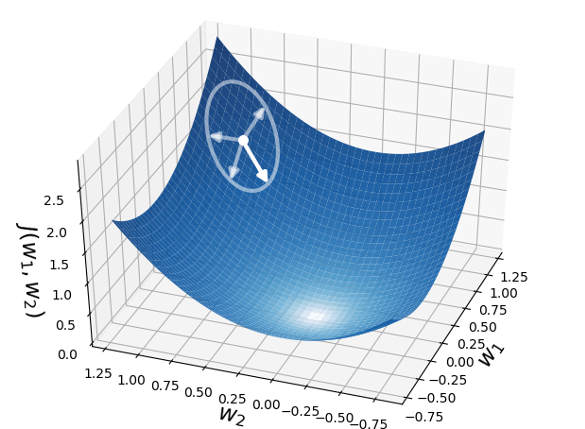 | 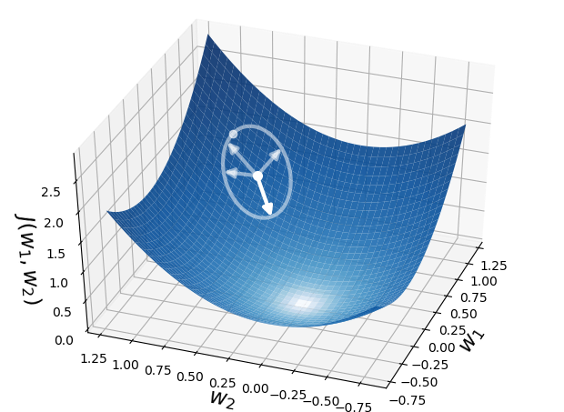 |

---

> **Implement a function that finds the minimum point of $J({\bf w})$ via random search.**

> The function takes the following inputs:
>
>- `cost_fun` - Function that can be called with one input array ${\bf w}$, returning a scalar value $J({\bf w})$.
>
>- `w_init` - Starting vector of the optimization process.
>
>- `alpha` - Scalar controling the length travelled at each iteration.
>
>- `epochs` - Number of iterations in the optimization process.
>
>- `n_points` - Number of random directions to consider at each iteration.
>
> The function returns two outputs:
>
>- `w` - Minimum point found by the algorithm.
>
>- `history` - Lists of points explored during the optimization process.

> *Hints:*
>
> - **Step 1.** Create a random matrix `directions` of shape `(n_points, w.size)`, where the rows have zero mean and unitary norm. 
> - **Step 2.** Compute the vectors `w + alpha * d` for each row `d` of `directions`, and stack them into a matrix `w_all`. Loop over each row `ws` of `w_all`, and append the value returned by `cost_fun(ws)` in the list `costs`. Find the index `min_idx` of the minimum element of `costs`.
> - **Step 3.** If the minimum element of `costs` is smaller than the current cost `J`, update it and replace the current point with the row of `w_all` at position `min_idx`.
> - **Step 4.** Modify the step-size: increase it if the current point was updated, otherwise decrease it. 

In [23]:
def random_search(cost_fun, w_init, alpha, epochs, n_points):
    """
    Finds the minimum of a function.
    
    Arguments:
    cost_fun -- cost function | callable that takes an input 'w' and returns the cost 'J(w)'
    w_init   -- initial point | vector of shape (N,)
    alpha    -- step-size     | scalar
    epochs   -- n. iterations | integer
    n_points -- n. directions | integer
    
    Returns:
    w -- minimum point | vector of shape (N,)
    """
    
    # Initialization
    w = np.array(w_init).ravel()
    J = cost_fun(w)
    
    # Refinement loop
    history = [w.copy()]
    for k in range(epochs):
                
        # Create a random matrix of shape (n_points, w.size) from the normal distribution
        directions = None # YOUR CODE HERE
        
        # Divide each row of 'directions' by its norm
        directions = None # YOUR CODE HERE
                
        # Compute 'w + alpha * d' for every row of 'directions'
        w_all = None # YOUR CODE HERE

        # Apply 'cost_fun' of each row of 'w_all'
        costs = None # YOUR CODE HERE

        # Find the index of the smallest element of 'costs'
        min_idx = None # YOUR CODE HERE

        # Update the current point
        if costs[min_idx] < J:
            
            # Select the element of 'costs' at position 'min_idx'
            J = None # YOUR CODE HERE
            
            # Select the row of 'w_all' at position 'min_idx'
            w = None # YOUR CODE HERE
            
            # Multiply the step-size by '1.5'
            alpha = None # YOUR CODE HERE
            
            history.append(w)
            
        else:
            
            # Divide the step-size by '1.5**0.25'
            alpha = None # YOUR CODE HERE
        
    return w, np.stack(history)

In [ ]:
ok.grade("random_search");

### Quiz 11

> **Use random search to find an approximate solution $(a,b)$ to the line fitting problem.**

$$ \operatorname*{minimize}_{a,b}\; \sum_{p=1}^P (a x_p + b - y_p)^2. $$

>*Hints:*
>- Your task is to set the arguments `w_init`, `alpha`, `epochs`, `n_points` of the function `random_search`.
>- Since the line fitting problem has two variables, set `w_init` to $[a_0, b_0]$ at your choice.
>- Try different values for `w_init`, `alpha`, `epochs`, `n_points` to see how they affect the solution found by random search.
>- The figure below shows the solution found by random search, along with all the points generated during the optimization process.

In [25]:
# Data for the line fitting problem (blue points in the figure above)
x, y = generate_points()

# Cost function (with 'x' and 'y' used as data)
cost_fun = lambda w: sse_cost(w, x, y)

# Initial point
w_init = None # YOUR CODE HERE

# Step-size
alpha = None # YOUR CODE HERE

# Number of iterations
epochs = None # YOUR CODE HERE

# Number of directions to search
n_points = None # YOUR CODE HERE

# Optimization
w, history = random_search(cost_fun, w_init, alpha, epochs, n_points)

# Visualization
show_history(w, history)

## Part 3. Cross-entropy method

The cross-entropy method is an optimization algorithm that finds the minimum of a function $J({\bf w})$ as follows.

- Start from a vector of means $\mu_0$ and a vector of standard deviations $\sigma_0$
- Fix a small step-size $\alpha\in \left]0,1\right]$
- Repeat for $k=0,1,\dots,K_{\max}$
  - **Step 1.** Draw some random points $\hat{ {\bf w} }_k^{(1)}, \dots, \hat{ {\bf w} }_k^{(S)}$ from the multivariate normal distribution with mean $\mu_k$ and variance $(\sigma_k + \epsilon)^2$.
  
  - **Step 2.** Sort the points according to their function values $
J\big(\hat{ {\bf w} }_k^{(i_1)}\big) \le \dots \le J\big(\hat{ {\bf w} }_k^{(i_S)}\big)$, and compute the mean $\overline{ {\bf \mu} }_k$ and the standard deviation $\overline{ {\bf \sigma} }_k$ of the first $B<S$ points (called "elite" points).

  - **Step 3.** Update the parameters of the distribution with an exponential moving average:

$$\begin{cases} 
{\bf \mu}_{k+1} = \alpha \, \overline{\bf \mu}_k + (1-\alpha) \, {\bf \mu}_{k} \\ 
{\bf \sigma}_{k+1} = \alpha \, \overline{\bf \sigma}_k + (1-\alpha) \, {\bf \sigma}_{k}
\end{cases}$$

Please refer to Section 2.5 in the [course notes](https://persointra.esiee.fr/~chierchg/optimization/02/cross_entropy.html) and the [lecture slides](https://esiee.blackboard.com) for more details.

### Quiz 12

Let's start by implementing the first step of the cross-entropy method, which is to draw some random points $\hat{ {\bf w} }_k^{(1)}, \dots, \hat{ {\bf w} }_k^{(S)}$ from the multivariate normal distribution with mean $\mu_k$ and variance $(\sigma_k + \epsilon)^2$. To do this, you can draw random vectors with zero mean and unitary variance, multiply them with the vector of standard deviations $\sigma_k$, and add them to the vector of means $\mu_k$. As illustrated in the figure below, this process generates points randomly scattered around $\mu_k$ at distance proportional to $\sigma_k$.

| Random points | Cost function |
|:---:|:---:|
| 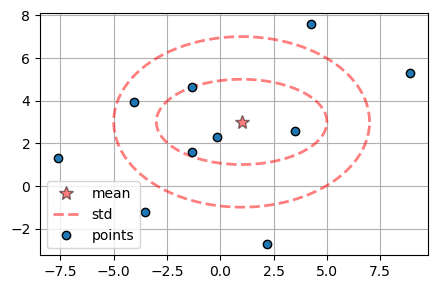 | 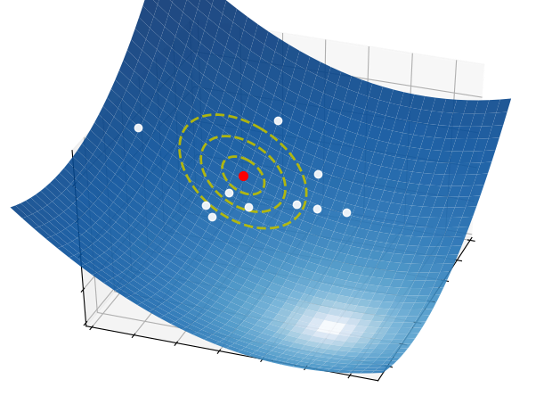 |

---

> **Create a matrix by drawing its rows from the multivariate normal distribution with mean $\mu_k$ and variance $(\sigma_k + \epsilon)^2$.**

> *Hints:*
> - Create a matrix of shape `(n_points, std.wsize)`, where each element is drawn from the normal distribution $\mathcal{N}(0,1)$.
> - Multiply each row by the vector `std + extra`, and add each row to the vector `mean`. This should automatically use broadcasting.
> - [`np.random.randn()`](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.randn.html)


In [26]:
np.random.seed(42)

# These are the items to work with
extra = 1
n_points = 10
mean = np.array([1, 3])
std = np.array([4, 2])

points = None # YOUR CODE HERE

In [ ]:
ok.grade("normal_sampling");

### Quiz 13

Now, let's focus on the second step of the cross-entropy method, which is to compute the mean and the standard deviation of a subset of the sampled points. You are given the points $\hat{ {\bf w} }_k^{(1)}, \dots, \hat{ {\bf w} }_k^{(S)}$, and the number $B < S$ of "elite" points to use for the computation of sample statistics. Your task is to 

1. find the indices $i_1, \dots, i_B, \dots,i_S$ that sort the points according to their function values 
$$\vphantom{\Bigg(} J\big(\hat{ {\bf w} }_k^{(i_1)}\big) \le \dots \le J\big(\hat{ {\bf w} }_k^{(i_B)}\big) \le \dots \le J\big(\hat{ {\bf w} }_k^{(i_S)}\big), $$ 

- take $\hat{ {\bf w} }_k^{(i_1)}, \dots, \hat{ {\bf w} }_k^{(i_B)}$ as the "elite" points (i.e., those associated to the $B$ smallest function values),

- compute the mean vector and the standard deviation vector of the "elite" points $\vphantom{\Big(}$

$$
\overline{ {\bf \mu} }_k = \sum_{b=1}^B \hat{ {\bf w} }_k^{(i_b)}
\qquad
\qquad
\overline{ {\bf \sigma} }_k = \sqrt{\frac{1}{B-1}\sum_{b=1}^B \big(\hat{ {\bf w} }_k^{(i_b)} - \overline{ {\bf \mu} }_k \big)^2}.
$$

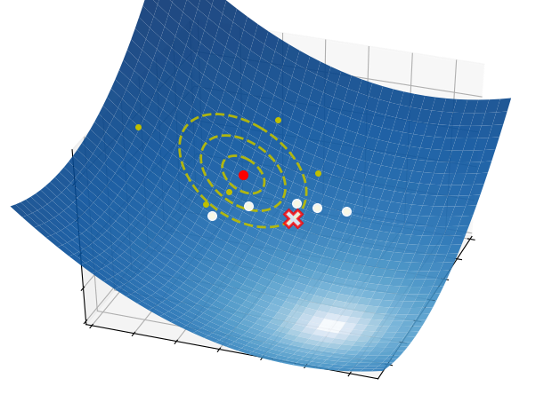

---

> **Compute the mean and the standard deviation of the "elite" points.**

> *Hints:*
>
> - Loop over each row `w` of the matrix `points`, call the function `cost_fun(ws)`, and append the returned value to the list `costs`. Remember that you can create a list in one line with the syntax `[do_something(row) for row in matrix]`.
>
> - Obtain the indices `idx` that would sort the elements of `costs`. See [`np.argsort()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html).
>
> - Slice `idx` by keeping the first `n_elites` indices, and throwing away the rest.
>
> - Copy the rows of `points` indicated by `idx` into `elites`.
>
> - Compute the mean of `elites` column by column. See [`np.mean()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html).
>
> - Compute the standard deviation of `elites` column by column. See [`np.std()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.std.html).

In [28]:
np.random.seed(42)

# These are the items to work with
cost_fun = lambda w: (w[0] - 1)**2 + (w[1] - 2)**2
points = np.random.randn(10, 3)
n_elites = 3

costs = None # YOUR CODE HERE
idx = None # YOUR CODE HERE
idx = None # YOUR CODE HERE
elites = None # YOUR CODE HERE
mean = None # YOUR CODE HERE
std  = None # YOUR CODE HERE

In [ ]:
ok.grade("elites");

### Quiz 14

You are now ready to implement the cross-entropy method by putting together the three steps of the algorithm.

| Iteration $k$ | Iteration $k+1$ |
|:---:|:---:|
| 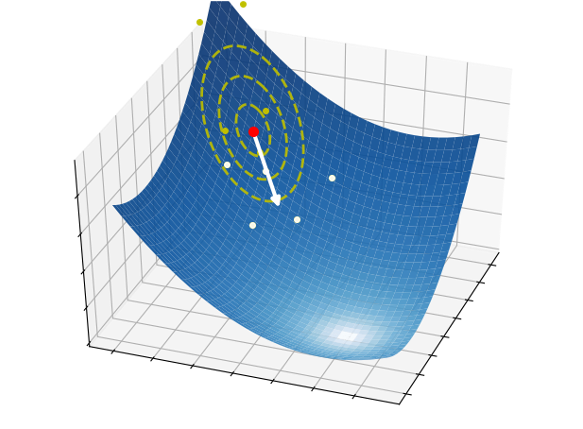 | 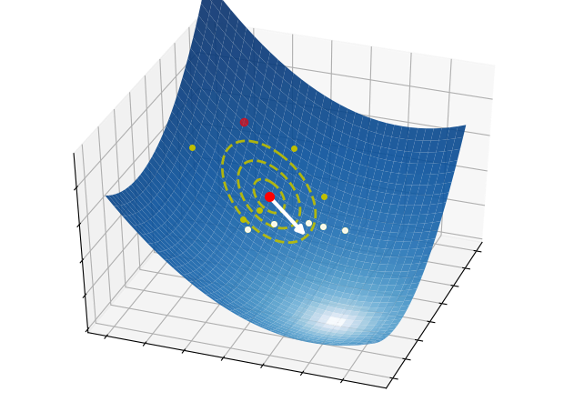 |

---

> **Implement a function that finds the minimum point of $J({\bf w})$ with the cross-entropy method.**


> The function takes the following inputs:
>
>- `cost_fun` - Function that can be called with one input array ${\bf w}$, returning a scalar value $J({\bf w})$.
>
>- `w_init` - Starting vector of the optimization process.
>
>- `alpha` - Scalar controling the length travelled at each iteration.
>
>- `epochs` - Number of iterations in the optimization process.
>
>- `n_points` - Number of points drawn at each iteration.
>
> The function returns two outputs:
>
>- `w` - Minimum point found by the algorithm.
>
>- `history` - Lists of points explored during the optimization process.


> *Hints:*
>
> - **Step 1.** Create a matrix `points` of shape `(n_points, std.size)` from the normal distribution with `mean` and `std+extra`.
>
> - **Step 2.** Apply `cost_fun(w)` to each row `w` of `points`, and store the results into the list `costs`. Find the indices `idx` of the `n_elites` smallest elements of `costs`. Copy the rows of `points` indicated by `idx` into `elites`. Compute the mean and the standard deviation of `elites` column-by-column, and store the results into the vectors `new_mean` and `new_std`.
>
> - **Step 3.** Use `new_mean` and `new_std` to update the vectors `mean` and `std` with a moving average (see formula above).

In [33]:
def cross_entropy_method(cost_fun, w_init, alpha, epochs, n_points):
    """
    Finds the minimum of a function.
    
    Arguments:
    cost_fun -- cost function | callable that takes 'w' and returns 'J(w)'
    w_init   -- initial point | vector of shape (N,)
    alpha    -- step-size     | scalar between 0 and 1
    epochs   -- n. iterations | integer
    n_points -- n. directions | integer
    
    Returns:
    w -- minimum point | vector of shape (N,)
    """
    np.random.seed(42)
    
    # Internal settings
    n_elites    = int(n_points * 0.2)
    init_std    = 5.0
    extra_std   = 2.0
    extra_decay = epochs * 0.8
    
    # Probability distribution
    mean = np.array(w_init, dtype=float).ravel()
    std  = np.ones_like(mean) * init_std
    
    # Refinement loop
    history = [mean]
    for k in range(epochs):
        
        extra = extra_std * max(1.0 - k / extra_decay, 0)
        
        # Create a matrix of shape `(n_points, std.size)` from the normal distribution with `mean` and `std+extra`
        points = None # YOUR CODE HERE
        
        # Apply 'cost_fun' to each row of 'points'
        costs = None # YOUR CODE HERE
        
        # Find the indices of the 'n_elites' smallest elements of 'costs'
        idx = None # YOUR CODE HERE
        idx = None # YOUR CODE HERE
        
        # Extract the rows of 'points' indicated by 'idx'
        elites = None # YOUR CODE HERE
        
        # Compute the mean and the std deviation of each column of 'elites'
        new_mean = None # YOUR CODE HERE
        new_std  = None # YOUR CODE HERE
        
        # Update 'mean' and 'std' with an moving average (see formula above)
        mean = None # YOUR CODE HERE
        std  = None # YOUR CODE HERE
        
        history.append(mean)

    return mean, np.stack(history)

In [ ]:
ok.grade("cross_entropy");

### Quiz 15

> **Use the cross-entropy method to find an approximate solution $(a,b)$ to the line fitting problem.**

$$ \operatorname*{minimize}_{a,b}\; \sum_{p=1}^P (a x_p + b - y_p)^2. $$

>*Hints:*
>- Your task is to set the arguments `w_init`, `alpha`, `epochs` of the function `cross_entropy_method`.
>- Since the line fitting problem has two variables, set `w_init` to $[a_0, b_0]$ at your choice.
>- Try different values for `w_init`, `alpha`, `epochs` to see how they affect the solution found by the algorithm.
>- The figure below shows the solution found by the algorithm, along with all the points generated during the optimization process.

In [35]:
# Data for the line fitting problem (blue points in the figure above)
x, y = generate_points()

# Cost function (with 'x' and 'y' used as data)
cost_fun = lambda w: sse_cost(w, x, y)

# Initial point
w_init = None # YOUR CODE HERE

# Step-size
alpha = None # YOUR CODE HERE

# Number of iterations
epochs = None # YOUR CODE HERE

# Number of points at each iteration
n_points = 50

# Optimization
w, history = cross_entropy_method(cost_fun, w_init, alpha, epochs, n_points)

# Visualization
show_history(w, history)